In [2]:
import MDAnalysis as mda
import numpy as np

z = mda.Universe('dumpT1400.lammpsdump', atom_style='ATOMS id type xs ys zs vx vy vz', in_memory=True)


#take 100 frames of the trajectory

z.trajectory = z.trajectory[0:500]


z.trajectory[1][:][:]

/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/topology/LAMMPSParser.py:632: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')
/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/core/universe.py:658: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


array([[31.465477 , 28.481653 , 16.782133 ],
       [29.55179  , 29.161715 , 18.802    ],
       [10.923183 , 16.96645  , 32.316483 ],
       ...,
       [17.814867 ,  0.694617 ,  4.881993 ],
       [ 1.1638876, 33.15496  , 31.59776  ],
       [26.885895 , 26.999016 , 32.24787  ]], dtype=float32)

# Incoherent scattering function based on magnitude of displacement

In [3]:

# Applying to overall displacement magnitude

dt = np.arange(1, len(z.trajectory), 1)

cum_disp = np.zeros((2048,len(z.trajectory), 3))
int_scat = np.zeros((len(dt)))

for i in range(0, len(z.trajectory)):
    cum_disp[:, i, :][:] = z.trajectory[i][:][:] 


from tqdm import tqdm

disp_3d = []
for i, n in tqdm(enumerate(dt), total = len(dt)):
    disp = np.concatenate([cum_disp[:, np.newaxis, i],
                            np.subtract(cum_disp[:, i + 1:], cum_disp[:, :-(i + 1)])],
                            axis=1)
    disp_3d.append(disp)
    int_scat[i] = np.mean(np.mean(np.exp(1j * np.linalg.norm(disp, axis = 2)), axis = 1))


  0%|          | 0/499 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_9326/707472972.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat[i] = np.mean(np.mean(np.exp(1j * np.linalg.norm(disp, axis = 2)), axis = 1))
100%|██████████| 499/499 [00:06<00:00, 80.19it/s] 


Text(0.5, 1.0, 'Incoherent Scattering - Us - q = 1?')

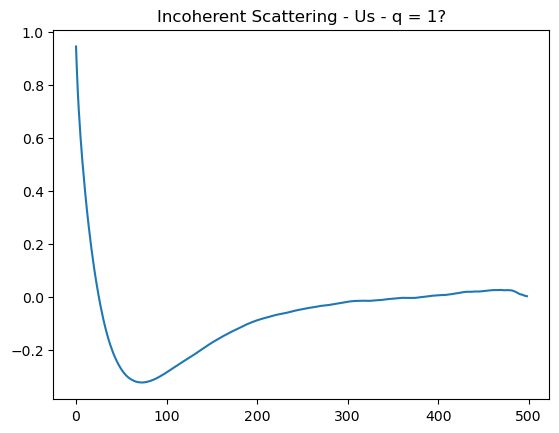

In [4]:
import matplotlib.pyplot as plt 

plt.plot(int_scat.T)
plt.title('Incoherent Scattering - Us - q = 1?')
#plt.xscale('log')

# Incoherent scattering function based on each individual vector x,y,z

In [5]:
# Applying to individual vectors (x,y,z)

dt = np.arange(1, len(z.trajectory), 1)

cum_disp = np.zeros((2048,len(z.trajectory), 3))
int_scat = np.zeros((len(dt),3))

for i in range(0, len(z.trajectory)):
    cum_disp[:, i, :][:] = z.trajectory[i][:][:] 


from tqdm import tqdm

disp_3d = []
for i, n in tqdm(enumerate(dt), total = len(dt)):
    disp = np.concatenate([cum_disp[:, np.newaxis, i],
                            np.subtract(cum_disp[:, i + 1:], cum_disp[:, :-(i + 1)])],
                            axis=1)
    disp_3d.append(disp)
    int_scat[i] = np.mean(np.mean(np.exp(1j * disp), axis=1),axis=0)

  0%|          | 0/499 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_9326/1161406851.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat[i] = np.mean(np.mean(np.exp(1j * disp), axis=1),axis=0)
100%|██████████| 499/499 [00:12<00:00, 40.06it/s] 


Text(0.5, 1.0, 'Individual components incohorent scattering')

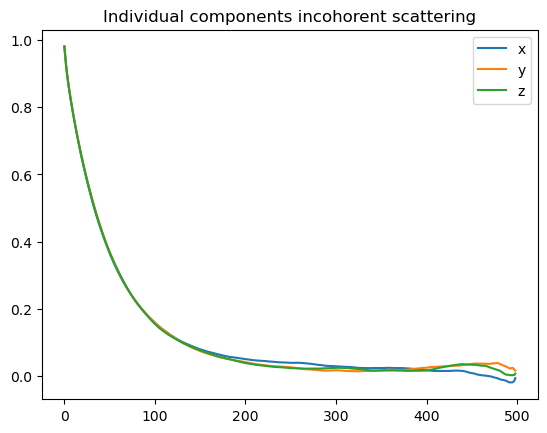

In [6]:
import matplotlib.pyplot as plt 

plt.plot(int_scat.T[0])
plt.plot(int_scat.T[1])
plt.plot(int_scat.T[2])
plt.legend(['x','y','z'])
plt.title('Individual components incohorent scattering')
#plt.xscale('log')

In [7]:
z.trajectory[1][:][:]

array([[31.465477 , 28.481653 , 16.782133 ],
       [29.55179  , 29.161715 , 18.802    ],
       [10.923183 , 16.96645  , 32.316483 ],
       ...,
       [17.814867 ,  0.694617 ,  4.881993 ],
       [ 1.1638876, 33.15496  , 31.59776  ],
       [26.885895 , 26.999016 , 32.24787  ]], dtype=float32)

# Incoherent scattering function as calculated by Dynosar based on random q-point sampling

In [8]:
import MDAnalysis as mda


from kinisi.analyze import DiffusionAnalyzer

import numpy as np
np.random.seed(42)
rng = np.random.RandomState(42)


import numpy as np
import matplotlib.pyplot as plt

from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.qpoints import get_spherical_qpoints
from dynasor.post_processing import compute_spherical_qpoint_average


In [9]:
trajectory_filename = 'dumpT1400.lammpsdump'
traj = Trajectory(
    trajectory_filename,
    trajectory_format='lammps_internal',
    frame_stop=500)

INFO: Trajectory file: dumpT1400.lammpsdump
INFO: Total number of particles: 2048


INFO: Number of atom types: 1
INFO: Number of atoms of type X: 2048
INFO: Simulation cell (in Angstrom):
[[34.032  0.     0.   ]
 [ 0.    34.032  0.   ]
 [ 0.     0.    34.032]]


In [55]:
from dynasor.qpoints import get_spherical_qpoints

cell  = np.array([[10, 0, 0], [0, 10, 0], [0, 0, 10]])

q_points2 = get_spherical_qpoints(cell, q_max=2, max_points=100)

In [57]:
q_points2

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.62831853],
       [0.62831853, 0.        , 0.        ],
       [0.        , 0.62831853, 0.        ],
       [0.62831853, 0.        , 0.62831853],
       [0.        , 0.62831853, 0.62831853],
       [0.62831853, 0.62831853, 0.        ],
       [0.62831853, 0.62831853, 0.62831853],
       [1.25663706, 0.        , 0.        ],
       [0.        , 1.25663706, 0.        ],
       [0.        , 0.        , 1.25663706],
       [1.25663706, 0.62831853, 0.        ],
       [0.        , 1.25663706, 0.62831853],
       [0.62831853, 0.        , 1.25663706],
       [0.62831853, 1.25663706, 0.        ],
       [1.25663706, 0.        , 0.62831853],
       [0.        , 0.62831853, 1.25663706],
       [0.62831853, 0.62831853, 1.25663706],
       [0.62831853, 1.25663706, 0.62831853],
       [1.25663706, 0.62831853, 0.62831853],
       [1.25663706, 0.        , 1.25663706],
       [1.25663706, 1.25663706, 0.        ],
       [0.

In [10]:
q_points = get_spherical_qpoints(traj.cell, q_max=2, max_points=2000)

sample_raw = compute_dynamic_structure_factors(
    traj, q_points, dt=1, window_size=500,
    window_step=500, calculate_currents=True, calculate_incoherent = True)


INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 1 fs
INFO: Time between consecutive frames used (dt * frame_step): 1 fs
INFO: Time window size (dt * frame_step * window_size): 500.0 fs
INFO: Angular frequency resolution: dw = 0.012566 2pi/fs = 8.271 meV
INFO: Maximum angular frequency (dw * window_size): 6.283185 2pi/fs = 4135.667 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 3.142 2pi/fs = 2067.8 meV
INFO: Calculating current (velocity) correlations
INFO: Calculating incoherent part (self-part) of correlations
INFO: Number of q-points: 820


In [11]:
sample_averaged = compute_spherical_qpoint_average(sample_raw, q_bins=40)

Text(0.5, 1.0, 'Incoherent Scattering - Dynasor - all q points, (q = 1.02  1/Å red)')

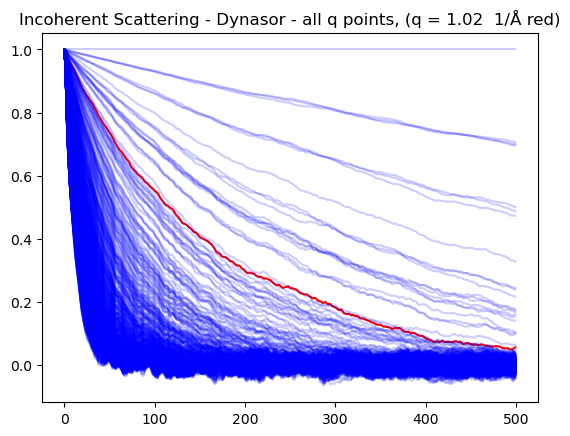

In [12]:
fig, ax = plt.subplots()

for i in range(0,820):
    if i == 20:
        ax.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'r')
    else:
        ax.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'b', alpha = 0.2)
plt.title('Incoherent Scattering - Dynasor - all q points, (q = 1.02  1/Å red)')

In [13]:
q_points[20].shape

(3,)

In [14]:
np.dot(disp[0][:][0], q_points[20])

10.40875042903584

In [15]:
np.dot(disp, q_points[20]).shape

(2048, 2)

In [16]:
disp.shape

(2048, 2, 3)

In [17]:
len(q_points)

820

In [18]:
# Applying to overall displacement magnitude

dt = np.arange(1, len(z.trajectory), 1)

cum_disp = np.zeros((2048,len(z.trajectory), 3))
int_scat = np.zeros((len(q_points),len(dt)))

for i in range(0, len(z.trajectory)):
    cum_disp[:, i, :][:] = z.trajectory[i][:][:] 


In [51]:

from tqdm import tqdm

disp_3d = []
for j in range(70, 80):
    for i, n in tqdm(enumerate(dt), total = len(dt)):
        disp = np.concatenate([cum_disp[:, np.newaxis, i],
                                np.subtract(cum_disp[:, i + 1:], cum_disp[:, :-(i + 1)])],
                                axis=1)
        #disp_3d.append(disp)
        int_scat[j, i] = np.mean(np.mean(np.exp(1j * np.dot(disp, q_points[j])), axis = 1))

  0%|          | 0/499 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_9326/593023886.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat[j, i] = np.mean(np.mean(np.exp(1j * np.dot(disp, q_points[j])), axis = 1))
100%|██████████| 499/499 [00:06<00:00, 72.17it/s] 


In [49]:
np.save('q_point_incoh.npy', int_scat)

Text(0.5, 1.0, 'dynasor implementation q[0:50]')

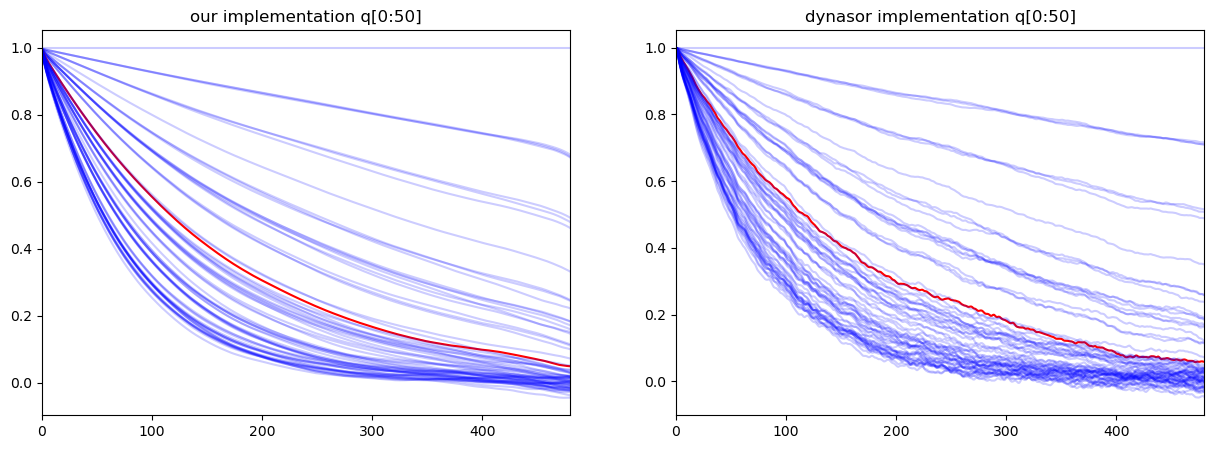

In [50]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (15,5))

for i in range(0,70):
    if i == 20:
        ax1.plot(int_scat[i].T, 'r')
        ax2.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'r')
    else:   
        ax1.plot(int_scat[i].T, 'b', alpha = 0.2)
        ax2.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'b', alpha = 0.2)

ax1.set_xlim(0, 480)
ax2.set_xlim(0, 480)

ax1.set_title('our implementation q[0:50]')
ax2.set_title('dynasor implementation q[0:50]')


